<a href="https://colab.research.google.com/github/mukunthans/DLAssignment1/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import wandb


In [11]:

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

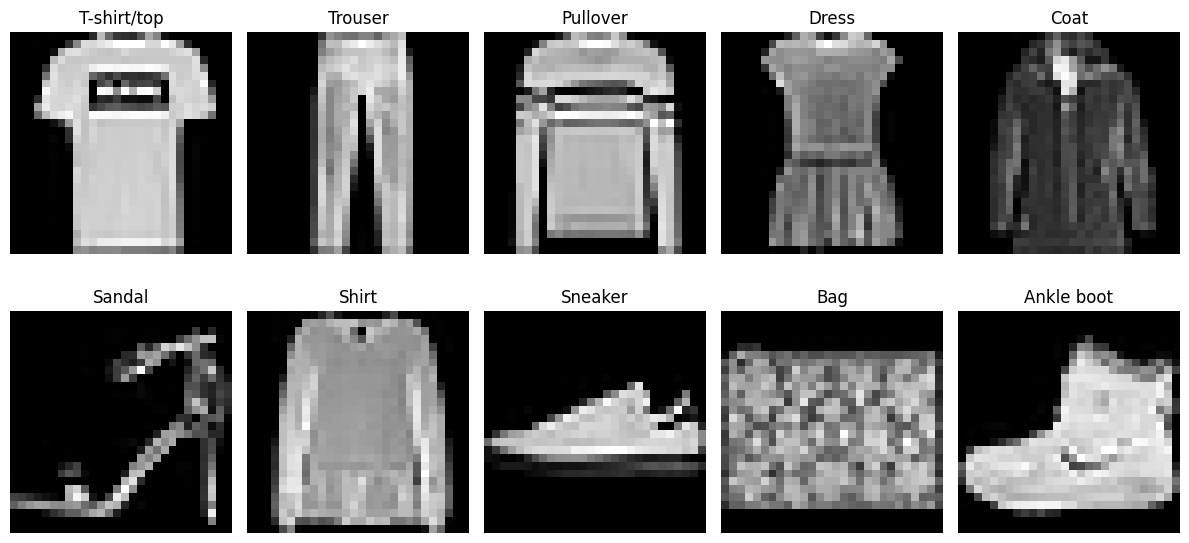

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for class_idx in range(10):
    idx = np.where(y_train == class_idx)[0][0]
    image = x_train[idx]
    axes[class_idx].imshow(image, cmap='gray')
    axes[class_idx].set_title(class_names[class_idx])
    axes[class_idx].axis('off')

plt.tight_layout()
plt.show()

In [2]:
# Identity Activation Function
def identity(x):
    return x

# Sigmoid Activation Function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Tanh Activation Function
def tanh(x):
    return np.tanh(x)

# ReLU Activation Function
def relu(x):
    return np.maximum(0, x)


In [18]:
class Feed_Forward:
    def __init__(self, hidden_units, num_hidden_layers, input_dim, output_dim,
                 weight_init="random", output_activation="softmax", initialize=True):
        self.hidden_units = hidden_units
        self.num_hidden_layers = num_hidden_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_init_type = weight_init
        self.output_activation_type = output_activation

        self.weights, self.biases = [], []
        if initialize:
            self.initialize_parameters()

    def initialize_parameters(self):
        # Initialize weights for input, hidden, and output layers
        self.weights.append(np.random.randn(self.input_dim, self.hidden_units))
        for _ in range(self.num_hidden_layers - 1):
            self.weights.append(np.random.randn(self.hidden_units, self.hidden_units))
        self.weights.append(np.random.randn(self.hidden_units, self.output_dim))
        if self.weight_init_type.lower() == "xavier":
            for i in range(len(self.weights)):
                self.weights[i] *= np.sqrt(1 / self.weights[i].shape[0])
        # Initialize biases for hidden and output layers
        self.biases = [np.zeros(self.hidden_units) for _ in range(self.num_hidden_layers)]
        self.biases.append(np.zeros(self.output_dim))

    def predict(self, x, activation_func):
        a = x
        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = activation_func(z)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [10]:
def compute_loss(loss_type, y, y_pred):
    if loss_type == "cross_entropy":
        return -np.sum(y * np.log(y_pred))  # Cross Entropy Loss
    elif loss_type == "mean_squared_error":
        return 0.5 * np.sum((y - y_pred) ** 2)  # Mean Squared Error Loss


In [16]:
class Optimizer():
    def __init__(self, nn, lr, optimizer, momentum, epsilon, beta, beta1, beta2, t, decay):
        self.nn = nn
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = t
        self.decay = decay
        self.v_w = [np.zeros_like(w) for w in nn.weights]
        self.v_b = [np.zeros_like(b) for b in nn.biases]
        self.s_w = [np.zeros_like(w) for w in nn.weights]
        self.s_b = [np.zeros_like(b) for b in nn.biases]
    def SGD(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.nn.weights[i] -= self.lr * (d_weights[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (d_biases[i] + self.decay * self.nn.biases[i])
    def MomentumGD(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.momentum * self.v_w[i] + d_weights[i]
            self.v_b[i] = self.momentum * self.v_b[i] + d_biases[i]
            self.nn.weights[i] -= self.lr * (self.v_w[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (self.v_b[i] + self.decay * self.nn.biases[i])
    def NAG(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.momentum * self.v_w[i] + d_weights[i]
            self.v_b[i] = self.momentum * self.v_b[i] + d_biases[i]
            self.nn.weights[i] -= self.lr * (self.momentum * self.v_w[i] + d_weights[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (self.momentum * self.v_b[i] + d_biases[i] + self.decay * self.nn.biases[i])
    def RMSProp(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.s_w[i] = self.beta * self.s_w[i] + (1 - self.beta) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta * self.s_b[i] + (1 - self.beta) * (d_biases[i] ** 2)
            self.nn.weights[i] -= self.lr * (d_weights[i] / (np.sqrt(self.s_w[i]) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (d_biases[i] / (np.sqrt(self.s_b[i]) + self.epsilon) + self.decay * self.nn.biases[i])
    def Adam(self, d_weights, d_biases):
        self.t += 1
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.beta1 * self.v_w[i] + (1 - self.beta1) * d_weights[i]
            self.v_b[i] = self.beta1 * self.v_b[i] + (1 - self.beta1) * d_biases[i]
            self.s_w[i] = self.beta2 * self.s_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta2 * self.s_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            v_w_hat = self.v_w[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta1 ** self.t)
            s_w_hat = self.s_w[i] / (1 - self.beta2 ** self.t)
            s_b_hat = self.s_b[i] / (1 - self.beta2 ** self.t)
            self.nn.weights[i] -= self.lr * (v_w_hat / (np.sqrt(s_w_hat) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (v_b_hat / (np.sqrt(s_b_hat) + self.epsilon) + self.decay * self.nn.biases[i])
    def NAdam(self, d_weights, d_biases):
        self.t += 1
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.beta1 * self.v_w[i] + (1 - self.beta1) * d_weights[i]
            self.v_b[i] = self.beta1 * self.v_b[i] + (1 - self.beta1) * d_biases[i]
            self.s_w[i] = self.beta2 * self.s_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta2 * self.s_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            v_w_hat = self.v_w[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta1 ** self.t)
            s_w_hat = self.s_w[i] / (1 - self.beta2 ** self.t)
            s_b_hat = self.s_b[i] / (1 - self.beta2 ** self.t)
            nesterov_v_w = self.beta1 * v_w_hat + (1 - self.beta1) * d_weights[i] / (1 - self.beta1 ** self.t)
            nesterov_v_b = self.beta1 * v_b_hat + (1 - self.beta1) * d_biases[i] / (1 - self.beta1 ** self.t)
            self.nn.weights[i] -= self.lr * (nesterov_v_w / (np.sqrt(s_w_hat) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (nesterov_v_b / (np.sqrt(s_b_hat) + self.epsilon) + self.decay * self.nn.biases[i])
    def optimize(self, d_weights, d_biases):
        opts = {
            "sgd": self.SGD,
            "momentum": self.MomentumGD,
            "nag": self.NAG,
            "rmsprop": self.RMSProp,
            "adam": self.Adam,
            "nadam": self.NAdam
        }
        opt_key = self.optimizer
        if opt_key == "nesterov":
            opt_key = "nag"
        opts[opt_key](d_weights, d_biases)


class NeuralNetworkTrainer:
    def __init__(self, nn, loss="cross_entropy", act_func="sigmoid", lr=0.001,
                 optimizer="sgd", momentum=0.9, epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.999, t=0, decay=0):
        self.nn = nn
        self.loss = loss
        self.activation_function = act_func
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = t
        self.decay = decay

        # Initialize optimizer instance with trainer parameters.
        self.optimizer_instance = Optimizer(nn, lr, optimizer, momentum, epsilon, beta, beta1, beta2, t, decay)

    def output_activation_derivative(self, y_pred):
        return np.diag(y_pred) - np.outer(y_pred, y_pred) if self.nn.output_activation_type == "softmax" else None

    def backward(self, y, y_pred):
        d_weights, d_biases, d_h, d_a = [], [], [], []
        d_h.append(y_pred - y)
        d_a.append(np.array([np.matmul((y_pred[i] - y[i]), self.output_activation_derivative(y_pred[i]))
                               for i in range(y_pred.shape[0])]))
        for i in range(self.nn.num_hidden_layers, 0, -1):
            d_weights.append(np.matmul(self.nn.post_activation[i].T, d_a[-1]))
            d_biases.append(np.sum(d_a[-1], axis=0))
            d_h.append(np.matmul(d_a[-1], self.nn.weights[i].T))
            d_a.append(d_h[-1] * self.activation_derivative(self.nn.post_activation[i]))
        d_weights.append(np.matmul(self.nn.post_activation[0].T, d_a[-1]))
        d_biases.append(np.sum(d_a[-1], axis=0))
        d_weights.reverse()
        d_biases.reverse()
        for i in range(len(d_weights)):
            d_weights[i] /= y.shape[0]
            d_biases[i] /= y.shape[0]
        return d_weights, d_biases

    def optimize(self, d_weights, d_biases):
        self.optimizer_instance.optimize(d_weights, d_biases)


In [19]:
x_test_flat = x_test.reshape(x_test.shape[0], -1) / 255.0
nn = Feed_Forward(hidden_units=128, num_hidden_layers=1, input_dim=784, output_dim=10,
                  weight_init="xavier", output_activation="softmax", initialize=True)

probabilities = nn.predict(x_test_flat, sigmoid)
print(probabilities[0])

[0.12307798 0.10917531 0.04226101 0.17151761 0.11046188 0.08531009
 0.13378174 0.05054072 0.11310158 0.06077207]


In [15]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m026 (cs24m026-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist, mnist
import wandb

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def tanh(x):
    return np.tanh(x)
def relu(x):
    return np.maximum(0, x)

# Feed-Forward Neural Network (stores activations for backprop)
class Feed_Forward:
    def __init__(self, hidden_units, num_hidden_layers, input_dim, output_dim,
                 weight_init="random", output_activation="softmax", initialize=True):
        self.hidden_units = hidden_units
        self.num_hidden_layers = num_hidden_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_init_type = weight_init
        self.output_activation_type = output_activation
        self.weights, self.biases = [], []
        if initialize:
            self.initialize_parameters()

    def initialize_parameters(self):
        self.weights.append(np.random.randn(self.input_dim, self.hidden_units))
        for _ in range(self.num_hidden_layers - 1):
            self.weights.append(np.random.randn(self.hidden_units, self.hidden_units))
        self.weights.append(np.random.randn(self.hidden_units, self.output_dim))
        if self.weight_init_type.lower() == "xavier":
            for i in range(len(self.weights)):
                self.weights[i] *= np.sqrt(1 / self.weights[i].shape[0])
        self.biases = [np.zeros(self.hidden_units) for _ in range(self.num_hidden_layers)]
        self.biases.append(np.zeros(self.output_dim))

    def predict(self, x, activation_func):
        self.pre_activation = [x]
        self.post_activation = [x]
        a = x
        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.pre_activation.append(z)
            a = activation_func(z)
            self.post_activation.append(a)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        self.pre_activation.append(z)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        a_out = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        self.post_activation.append(a_out)
        return a_out

def loss_func(loss_type, y, y_pred):
    if loss_type == "cross_entropy":
        return -np.sum(y * np.log(y_pred))
    elif loss_type == "mean_squared_error":
        return np.sum((y - y_pred)**2) / 2
    else:
        raise Exception("Invalid loss function")

def get_activation_derivative(a, activation):
    if activation == "sigmoid":
        return a * (1 - a)
    elif activation == "tanh":
        return 1 - a**2
    elif activation == "relu":
        return (a > 0).astype(int)
    else:
        return np.ones(a.shape)

# Optimizer class (unchanged)
class Optimizer():
    def __init__(self, nn, lr, optimizer, momentum, epsilon, beta, beta1, beta2, t, decay):
        self.nn = nn
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = t
        self.decay = decay
        self.v_w = [np.zeros_like(w) for w in nn.weights]
        self.v_b = [np.zeros_like(b) for b in nn.biases]
        self.s_w = [np.zeros_like(w) for w in nn.weights]
        self.s_b = [np.zeros_like(b) for b in nn.biases]
    def SGD(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.nn.weights[i] -= self.lr * (d_weights[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (d_biases[i] + self.decay * self.nn.biases[i])
    def MomentumGD(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.momentum * self.v_w[i] + d_weights[i]
            self.v_b[i] = self.momentum * self.v_b[i] + d_biases[i]
            self.nn.weights[i] -= self.lr * (self.v_w[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (self.v_b[i] + self.decay * self.nn.biases[i])
    def NAG(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.momentum * self.v_w[i] + d_weights[i]
            self.v_b[i] = self.momentum * self.v_b[i] + d_biases[i]
            self.nn.weights[i] -= self.lr * (self.momentum * self.v_w[i] + d_weights[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (self.momentum * self.v_b[i] + d_biases[i] + self.decay * self.nn.biases[i])
    def RMSProp(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.s_w[i] = self.beta * self.s_w[i] + (1 - self.beta) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta * self.s_b[i] + (1 - self.beta) * (d_biases[i] ** 2)
            self.nn.weights[i] -= self.lr * (d_weights[i] / (np.sqrt(self.s_w[i]) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (d_biases[i] / (np.sqrt(self.s_b[i]) + self.epsilon) + self.decay * self.nn.biases[i])
    def Adam(self, d_weights, d_biases):
        self.t += 1
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.beta1 * self.v_w[i] + (1 - self.beta1) * d_weights[i]
            self.v_b[i] = self.beta1 * self.v_b[i] + (1 - self.beta1) * d_biases[i]
            self.s_w[i] = self.beta2 * self.s_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta2 * self.s_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            v_w_hat = self.v_w[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta1 ** self.t)
            s_w_hat = self.s_w[i] / (1 - self.beta2 ** self.t)
            s_b_hat = self.s_b[i] / (1 - self.beta2 ** self.t)
            self.nn.weights[i] -= self.lr * (v_w_hat / (np.sqrt(s_w_hat) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (v_b_hat / (np.sqrt(s_b_hat) + self.epsilon) + self.decay * self.nn.biases[i])
    def NAdam(self, d_weights, d_biases):
        self.t += 1
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.beta1 * self.v_w[i] + (1 - self.beta1) * d_weights[i]
            self.v_b[i] = self.beta1 * self.v_b[i] + (1 - self.beta1) * d_biases[i]
            self.s_w[i] = self.beta2 * self.s_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta2 * self.s_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            v_w_hat = self.v_w[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta1 ** self.t)
            s_w_hat = self.s_w[i] / (1 - self.beta2 ** self.t)
            s_b_hat = self.s_b[i] / (1 - self.beta2 ** self.t)
            nesterov_v_w = self.beta1 * v_w_hat + (1 - self.beta1) * d_weights[i] / (1 - self.beta1 ** self.t)
            nesterov_v_b = self.beta1 * v_b_hat + (1 - self.beta1) * d_biases[i] / (1 - self.beta1 ** self.t)
            self.nn.weights[i] -= self.lr * (nesterov_v_w / (np.sqrt(s_w_hat) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (nesterov_v_b / (np.sqrt(s_b_hat) + self.epsilon) + self.decay * self.nn.biases[i])
    def optimize(self, d_weights, d_biases):
        opts = {
            "sgd": self.SGD,
            "momentum": self.MomentumGD,
            "nag": self.NAG,
            "rmsprop": self.RMSProp,
            "adam": self.Adam,
            "nadam": self.NAdam
        }
        opt_key = self.optimizer
        if opt_key == "nesterov":
            opt_key = "nag"
        opts[opt_key](d_weights, d_biases)

class NeuralNetworkTrainer:
    def __init__(self, nn, loss="cross_entropy", act_func="sigmoid", lr=0.001, optimizer="sgd", momentum=0.9, epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.999, t=0, decay=0):
        self.nn = nn
        self.loss = loss
        self.activation_function = act_func
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = t
        self.decay = decay
        self.optimizer_instance = Optimizer(nn, lr, optimizer, momentum, epsilon, beta, beta1, beta2, t, decay)
    def output_activation_derivative(self, y_pred):
        return np.diag(y_pred) - np.outer(y_pred, y_pred) if self.nn.output_activation_type == "softmax" else None
    def activation_derivative(self, a):
        return get_activation_derivative(a, self.activation_function)
    def backward(self, y, y_pred):
        d_weights, d_biases, d_h, d_a = [], [], [], []
        d_h.append(y_pred - y)
        d_a.append(np.array([np.matmul((y_pred[i] - y[i]), self.output_activation_derivative(y_pred[i]))
                               for i in range(y_pred.shape[0])]))
        for i in range(self.nn.num_hidden_layers, 0, -1):
            d_weights.append(np.matmul(self.nn.post_activation[i].T, d_a[-1]))
            d_biases.append(np.sum(d_a[-1], axis=0))
            d_h.append(np.matmul(d_a[-1], self.nn.weights[i].T))
            d_a.append(d_h[-1] * self.activation_derivative(self.nn.post_activation[i]))
        d_weights.append(np.matmul(self.nn.post_activation[0].T, d_a[-1]))
        d_biases.append(np.sum(d_a[-1], axis=0))
        d_weights.reverse()
        d_biases.reverse()
        for i in range(len(d_weights)):
            d_weights[i] /= y.shape[0]
            d_biases[i] /= y.shape[0]
        return d_weights, d_biases
    def optimize(self, d_weights, d_biases):
        self.optimizer_instance.optimize(d_weights, d_biases)

sweep_configuration = {
    'method': 'random',
    'name': 'fashion_mnist_sweep',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'neurons': {'values': [32, 64, 128]},
        'decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},
        'momentum': {'values': [0.7, 0.8, 0.9]},
        'input_size': {'value': 784},
        'output_size': {'value': 10},
        'loss': {'value': 'cross_entropy'},
        'beta': {'value': 0.9},
        'beta1': {'value': 0.9},
        'beta2': {'value': 0.999},
        'output_activation': {'value': 'softmax'},
        'epsilon': {'value': 1e-8},
        'dataset': {'value': 'fashion_mnist'}
    }
}

def load_data(type, dataset='fashion_mnist'):
    x, y, x_test, y_test = None, None, None, None
    if dataset == 'mnist':
        (x, y), (x_test, y_test) = mnist.load_data()
    elif dataset == 'fashion_mnist':
        (x, y), (x_test, y_test) = fashion_mnist.load_data()
    if type == 'train':
        x = x.reshape(x.shape[0], 784) / 255.0
        y = np.eye(10)[y]
        return x, y
    elif type == 'test':
        x_test = x_test.reshape(x_test.shape[0], 784) / 255.0
        y_test = np.eye(10)[y_test]
        return x_test, y_test

def train_sweep():
    run = wandb.init()
    parameters = wandb.config
    run.name = f"{parameters['activation']}_neurons={parameters['neurons']}_layers={parameters['hidden_layers']}_lr={parameters['learning_rate']}_batch={parameters['batch_size']}_opt={parameters['optimizer']}_mom={parameters['momentum']}_init={parameters['weight_init']}"
    x_train, y_train = load_data('train', dataset=parameters['dataset'])

    act_funcs = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu}
    act_func = act_funcs[parameters['activation']]

    nn = Feed_Forward(hidden_units=parameters['neurons'],
                      num_hidden_layers=parameters['hidden_layers'],
                      input_dim=parameters['input_size'],
                      output_dim=parameters['output_size'],
                      weight_init=parameters['weight_init'],
                      output_activation=parameters['output_activation'],
                      initialize=True)
    # NeuralNetworkTrainer now includes backward functionality
    trainer = NeuralNetworkTrainer(nn=nn,
                                   loss=parameters['loss'],
                                   act_func=parameters['activation'],
                                   lr=parameters['learning_rate'],
                                   optimizer=parameters['optimizer'],
                                   momentum=parameters['momentum'],
                                   epsilon=parameters['epsilon'],
                                   beta=parameters['beta'],
                                   beta1=parameters['beta1'],
                                   beta2=parameters['beta2'],
                                   t=0,
                                   decay=parameters['decay'])
    batch_size = parameters['batch_size']
    x_train_act, x_val, y_train_act, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
    print("Initial Accuracy: {}".format(np.sum(np.argmax(nn.predict(x_train, act_func), axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0]))
    for epoch in range(parameters['epochs']):
        for i in range(0, x_train_act.shape[0], batch_size):
            x_batch = x_train_act[i:i+batch_size]
            y_batch = y_train_act[i:i+batch_size]
            y_pred = nn.predict(x_batch, act_func)
            d_weights, d_biases = trainer.backward(y_batch, y_pred)
            trainer.optimize(d_weights, d_biases)
        trainer.optimizer_instance.t += 1
        y_pred_train = nn.predict(x_train_act, act_func)
        print("Epoch: {}, Loss: {}".format(epoch + 1, loss_func(parameters['loss'], y_train_act, y_pred_train)))
        print("Accuracy: {}".format(np.sum(np.argmax(y_pred_train, axis=1) == np.argmax(y_train_act, axis=1)) / y_train_act.shape[0]))
        train_loss = loss_func(parameters['loss'], y_train_act, y_pred_train)
        train_accuracy = np.sum(np.argmax(y_pred_train, axis=1) == np.argmax(y_train_act, axis=1)) / y_train_act.shape[0]
        y_pred_val = nn.predict(x_val, act_func)
        val_loss = loss_func(parameters['loss'], y_val, y_pred_val) / x_val.shape[0]
        val_accuracy = np.sum(np.argmax(y_pred_val, axis=1) == np.argmax(y_val, axis=1)) / y_val.shape[0]
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })
    x_test, y_test = load_data('test', dataset=parameters['dataset'])
    y_pred_test = nn.predict(x_test, act_func)
    test_loss = loss_func(parameters['loss'], y_test, y_pred_test)
    test_accuracy = np.sum(np.argmax(y_pred_test, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("Test Accuracy: {}".format(test_accuracy))
    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    })
    return nn

wandb.login()
wandb_id = wandb.sweep(sweep_configuration, project="SWEEP_PROJECT1")
wandb.agent(wandb_id, function=train_sweep, count=100)
wandb.finish()


Create sweep with ID: zoq6nmo6
Sweep URL: https://wandb.ai/cs24m026-iit-madras-foundation/SWEEP_PROJECT1/sweeps/zoq6nmo6


wandb: Agent Starting Run: 7iki6jq1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.0845


<ipython-input-30-0b5eb079e362>:59: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(y_pred))
<ipython-input-30-0b5eb079e362>:59: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(y_pred))


Epoch: 1, Loss: nan
Accuracy: 0.13127777777777777
Epoch: 2, Loss: nan
Accuracy: 0.14912962962962964
Epoch: 3, Loss: nan
Accuracy: 0.1622037037037037
Epoch: 4, Loss: nan
Accuracy: 0.17066666666666666
Epoch: 5, Loss: nan
Accuracy: 0.17994444444444443
Epoch: 6, Loss: nan
Accuracy: 0.1765
Epoch: 7, Loss: nan
Accuracy: 0.1947962962962963
Epoch: 8, Loss: nan
Accuracy: 0.19953703703703704
Epoch: 9, Loss: nan
Accuracy: 0.20503703703703705
Epoch: 10, Loss: nan
Accuracy: 0.22625925925925927
Test Accuracy: 0.2224


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_accuracy,▁▂▃▄▅▄▆▆▆█
val_accuracy,▁▂▃▄▅▄▆▆▆█
epoch,10
test_accuracy,0.2224
test_loss,nan
train_accuracy,0.22626
train_loss,nan
val_accuracy,0.225
val_loss,nan


wandb: Agent Starting Run: bi8w0qh1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 29759.868776914424
Accuracy: 0.833574074074074
Epoch: 2, Loss: 29458.307013731675
Accuracy: 0.8378148148148148
Epoch: 3, Loss: 29450.597810675972
Accuracy: 0.8382777777777778
Epoch: 4, Loss: 29389.994956988776
Accuracy: 0.8388148148148148
Epoch: 5, Loss: 29337.532579633462
Accuracy: 0.8394074074074074
Epoch: 6, Loss: 29287.087591028445
Accuracy: 0.8393518518518519
Epoch: 7, Loss: 29237.2010808898
Accuracy: 0.8398518518518518
Epoch: 8, Loss: 29236.274380520823
Accuracy: 0.8403703703703703
Epoch: 9, Loss: 29264.915477788727
Accuracy: 0.8405185185185186
Epoch: 10, Loss: 29313.814247601094
Accuracy: 0.8406666666666667
Test Accuracy: 0.8275


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▄▃▂▂▁▁▁▂
val_accuracy,▁█▇▆▅▅▅▆██
val_loss,█▃▄▃▂▂▁▁▂▃
epoch,10
test_accuracy,0.8275
test_loss,5720.83045
train_accuracy,0.84067


wandb: Agent Starting Run: 9qu8pqb5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.17475
Epoch: 1, Loss: 122969.942191434
Accuracy: 0.1799074074074074
Epoch: 2, Loss: 122737.39223614737
Accuracy: 0.18438888888888888
Epoch: 3, Loss: 122500.87929830184
Accuracy: 0.1874259259259259
Epoch: 4, Loss: 122261.48390385885
Accuracy: 0.18955555555555556
Epoch: 5, Loss: 122015.67627328238
Accuracy: 0.19140740740740741
Test Accuracy: 0.1919


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇█
train_loss,█▆▅▃▁
val_accuracy,▁▄▅▇█
val_loss,█▆▅▃▁
epoch,5
test_accuracy,0.1919
test_loss,22597.40031
train_accuracy,0.19141


wandb: Agent Starting Run: fn9e7fpd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.10315
Epoch: 1, Loss: nan
Accuracy: 0.11838888888888889
Epoch: 2, Loss: nan
Accuracy: 0.12696296296296297
Epoch: 3, Loss: nan
Accuracy: 0.13372222222222221
Epoch: 4, Loss: nan
Accuracy: 0.13924074074074075
Epoch: 5, Loss: nan
Accuracy: 0.14444444444444443
Test Accuracy: 0.1421


epoch,▁▃▅▆█
test_accuracy,▁
train_accuracy,▁▃▅▇█
val_accuracy,▁▄▅▇█
epoch,5
test_accuracy,0.1421
test_loss,nan
train_accuracy,0.14444
train_loss,nan
val_accuracy,0.14467
val_loss,nan


wandb: Agent Starting Run: ew6ie7ww with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 128
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.14513333333333334
Epoch: 1, Loss: 369312.29038921994
Accuracy: 0.17492592592592593
Epoch: 2, Loss: 124064.97645091786
Accuracy: 0.3746481481481482
Epoch: 3, Loss: 124339.09059212689
Accuracy: 0.10092592592592593
Epoch: 4, Loss: 124339.58377015778
Accuracy: 0.10092592592592593
Epoch: 5, Loss: 124339.58675595374
Accuracy: 0.10092592592592593
Test Accuracy: 0.1


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▃█▁▁▁
train_loss,█▁▁▁▁
val_accuracy,▃█▁▁▁
val_loss,█▁▁▁▁
epoch,5
test_accuracy,0.1
test_loss,23025.85096
train_accuracy,0.10093


wandb: Agent Starting Run: qtx9170k with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.038983333333333335
Epoch: 1, Loss: nan
Accuracy: 0.06609259259259259
Epoch: 2, Loss: nan
Accuracy: 0.09944444444444445
Epoch: 3, Loss: nan
Accuracy: 0.09944444444444445
Epoch: 4, Loss: nan
Accuracy: 0.09944444444444445
Epoch: 5, Loss: nan
Accuracy: 0.09944444444444445
Epoch: 6, Loss: nan
Accuracy: 0.09944444444444445
Epoch: 7, Loss: nan
Accuracy: 0.09944444444444445
Epoch: 8, Loss: nan
Accuracy: 0.09944444444444445
Epoch: 9, Loss: nan
Accuracy: 0.09944444444444445
Epoch: 10, Loss: nan
Accuracy: 0.09944444444444445
Test Accuracy: 0.0999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_accuracy,▁█████████
val_accuracy,▁█████████
epoch,10
test_accuracy,0.0999
test_loss,nan
train_accuracy,0.09944
train_loss,nan
val_accuracy,0.10333
val_loss,nan


wandb: Agent Starting Run: yx0mkmeg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.07333333333333333
Epoch: 1, Loss: 990625.2656699078
Accuracy: 0.07718518518518519
Epoch: 2, Loss: 984848.9290395998
Accuracy: 0.07992592592592593
Epoch: 3, Loss: 979797.3933719744
Accuracy: 0.08227777777777778
Epoch: 4, Loss: 975176.09909535
Accuracy: 0.08457407407407408
Epoch: 5, Loss: 970807.2051950018
Accuracy: 0.0865
Epoch: 6, Loss: 966433.0585412622
Accuracy: 0.08848148148148148
Epoch: 7, Loss: 962316.8895911095
Accuracy: 0.09085185185185185
Epoch: 8, Loss: 958361.2719015614
Accuracy: 0.0927037037037037
Epoch: 9, Loss: 954749.2269465744
Accuracy: 0.09492592592592593
Epoch: 10, Loss: 951263.241278979
Accuracy: 0.09664814814814815
Test Accuracy: 0.0895


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▄▄▅▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▁▁▂▃▃▅▆▇█
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
test_accuracy,0.0895
test_loss,175443.48368
train_accuracy,0.09665


wandb: Agent Starting Run: lt1h7snk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.10205
Epoch: 1, Loss: 122620.66457020126
Accuracy: 0.21116666666666667
Epoch: 2, Loss: 120168.03706244774
Accuracy: 0.27216666666666667
Epoch: 3, Loss: 116331.55469612477
Accuracy: 0.2866111111111111
Epoch: 4, Loss: 110432.34235420763
Accuracy: 0.28955555555555557
Epoch: 5, Loss: 103638.68608944709
Accuracy: 0.31287037037037035
Test Accuracy: 0.313


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▆█
train_loss,█▇▆▄▁
val_accuracy,▁▅▆▆█
val_loss,█▇▆▄▁
epoch,5
test_accuracy,0.313
test_loss,19221.78538
train_accuracy,0.31287


wandb: Agent Starting Run: 6o6vrtta with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.09653333333333333
Epoch: 1, Loss: 642698.3752748941
Accuracy: 0.10192592592592592
Epoch: 2, Loss: 612526.0701980559
Accuracy: 0.10444444444444445
Epoch: 3, Loss: 584495.6853553853
Accuracy: 0.10668518518518519
Epoch: 4, Loss: 556790.2648230261
Accuracy: 0.10864814814814815
Epoch: 5, Loss: 530379.0760799447
Accuracy: 0.11122222222222222
Test Accuracy: 0.1004


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▆█
train_loss,█▆▄▃▁
val_accuracy,▁▃▃▄█
val_loss,█▆▄▃▁
epoch,5
test_accuracy,0.1004
test_loss,99517.9577
train_accuracy,0.11122


wandb: Agent Starting Run: iwjcdfna with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.09775
Epoch: 1, Loss: nan
Accuracy: 0.19714814814814816
Epoch: 2, Loss: nan
Accuracy: 0.1789814814814815
Epoch: 3, Loss: nan
Accuracy: 0.19057407407407406
Epoch: 4, Loss: nan
Accuracy: 0.18566666666666667
Epoch: 5, Loss: nan
Accuracy: 0.1927222222222222
Epoch: 6, Loss: nan
Accuracy: 0.19416666666666665
Epoch: 7, Loss: nan
Accuracy: 0.19137037037037036
Epoch: 8, Loss: nan
Accuracy: 0.10092592592592593
Epoch: 9, Loss: nan
Accuracy: 0.1958148148148148
Epoch: 10, Loss: nan
Accuracy: 0.1953888888888889
Test Accuracy: 0.1954


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_accuracy,█▇█▇███▁██
val_accuracy,█▇█▇███▁██
epoch,10
test_accuracy,0.1954
test_loss,nan
train_accuracy,0.19539
train_loss,nan
val_accuracy,0.201
val_loss,nan


wandb: Agent Starting Run: e2ra74ya with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.06661666666666667
Epoch: 1, Loss: nan
Accuracy: 0.1377962962962963
Epoch: 2, Loss: nan
Accuracy: 0.15194444444444444
Epoch: 3, Loss: nan
Accuracy: 0.18905555555555556
Epoch: 4, Loss: nan
Accuracy: 0.19794444444444445
Epoch: 5, Loss: nan
Accuracy: 0.20585185185185184
Test Accuracy: 0.2059


epoch,▁▃▅▆█
test_accuracy,▁
train_accuracy,▁▂▆▇█
val_accuracy,▁▂▆▇█
epoch,5
test_accuracy,0.2059
test_loss,nan
train_accuracy,0.20585
train_loss,nan
val_accuracy,0.20033
val_loss,nan


wandb: Agent Starting Run: o0t91uud with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.10723333333333333
Epoch: 1, Loss: 22175.85965703688
Accuracy: 0.8650740740740741
Epoch: 2, Loss: 20090.98312652317
Accuracy: 0.8768518518518519
Epoch: 3, Loss: 20115.488438528962
Accuracy: 0.8769629629629629
Epoch: 4, Loss: 19647.971036851148
Accuracy: 0.8810555555555556
Epoch: 5, Loss: 19373.513925437765
Accuracy: 0.8823333333333333
Epoch: 6, Loss: 19404.254186185717
Accuracy: 0.8843518518518518
Epoch: 7, Loss: 19049.681631487816
Accuracy: 0.8861296296296296
Epoch: 8, Loss: 18712.36029879655
Accuracy: 0.8892407407407408
Epoch: 9, Loss: 18982.400777736144
Accuracy: 0.8861296296296296
Epoch: 10, Loss: 18992.140680080425
Accuracy: 0.8840370370370371
Test Accuracy: 0.8623


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▄▆▆▇▇█▇▆
train_loss,█▄▄▃▂▂▂▁▂▂
val_accuracy,▁▅▅▆▆▆▆█▆▇
val_loss,█▃▄▃▂▃▂▁▂▁
epoch,10
test_accuracy,0.8623
test_loss,4113.61062
train_accuracy,0.88404


wandb: Agent Starting Run: ddxrebok with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.11128333333333333
Epoch: 1, Loss: 799161.9153708734
Accuracy: 0.1394074074074074
Epoch: 2, Loss: 765145.5897016941
Accuracy: 0.15785185185185185
Epoch: 3, Loss: 719366.4907262687
Accuracy: 0.1814074074074074
Epoch: 4, Loss: 680881.9573495307
Accuracy: 0.197
Epoch: 5, Loss: 649070.603664458
Accuracy: 0.21638888888888888
Test Accuracy: 0.2138


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▆█
train_loss,█▆▄▂▁
val_accuracy,▁▃▅▆█
val_loss,█▆▄▃▁
epoch,5
test_accuracy,0.2138
test_loss,120472.24735
train_accuracy,0.21639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qvf9gqd3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.09616666666666666
Epoch: 1, Loss: 114914.41086674161
Accuracy: 0.5975555555555555
Epoch: 2, Loss: 43779.73284932839
Accuracy: 0.7435185185185185
Epoch: 3, Loss: 38552.37800082425
Accuracy: 0.7732222222222223
Epoch: 4, Loss: 35641.12840149529
Accuracy: 0.7887037037037037
Epoch: 5, Loss: 33606.43731649333
Accuracy: 0.8009074074074074
Epoch: 6, Loss: 32146.338257675863
Accuracy: 0.8096481481481481
Epoch: 7, Loss: 31019.72768889381
Accuracy: 0.8173518518518519
Epoch: 8, Loss: 30092.852308939237
Accuracy: 0.822925925925926
Epoch: 9, Loss: 29305.50766575178
Accuracy: 0.8275555555555556
Epoch: 10, Loss: 28623.914758983952
Accuracy: 0.8316851851851852
Test Accuracy: 0.8001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇▇▇████
train_loss,█▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.8001
test_loss,6205.89117
train_accuracy,0.83169


wandb: Agent Starting Run: m9sv7mai with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.12993333333333335
Epoch: 1, Loss: 43161.200143463015
Accuracy: 0.750462962962963
Epoch: 2, Loss: 35223.11432115458
Accuracy: 0.7858148148148149
Epoch: 3, Loss: 32004.284534199454
Accuracy: 0.8027777777777778
Epoch: 4, Loss: 30017.53227582399
Accuracy: 0.816
Epoch: 5, Loss: 28619.767220972466
Accuracy: 0.8233518518518519
Epoch: 6, Loss: 27428.92174730247
Accuracy: 0.8297592592592593
Epoch: 7, Loss: 26522.63305619462
Accuracy: 0.8352037037037037
Epoch: 8, Loss: 25702.706011368366
Accuracy: 0.8398518518518518
Epoch: 9, Loss: 24973.736891241326
Accuracy: 0.8447222222222223
Epoch: 10, Loss: 24371.743962497192
Accuracy: 0.8488888888888889
Test Accuracy: 0.8245


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8245
test_loss,5103.81157
train_accuracy,0.84889


wandb: Agent Starting Run: 2ig2ihw0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.11743333333333333
Epoch: 1, Loss: 97907.08715664918
Accuracy: 0.4615740740740741
Epoch: 2, Loss: 66646.4928948572
Accuracy: 0.6515
Epoch: 3, Loss: 47847.9074083859
Accuracy: 0.7194074074074074
Epoch: 4, Loss: 42028.76492962184
Accuracy: 0.7475925925925926
Epoch: 5, Loss: 38833.147281260615
Accuracy: 0.7636111111111111
Test Accuracy: 0.7499


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.7499
test_loss,7592.37282
train_accuracy,0.76361


wandb: Agent Starting Run: t89wrkbb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.08885
Epoch: 1, Loss: 36649.84419469066
Accuracy: 0.7977592592592593
Epoch: 2, Loss: 29238.05504981331
Accuracy: 0.8401481481481482
Epoch: 3, Loss: 28080.941432814892
Accuracy: 0.8470185185185185
Epoch: 4, Loss: 28076.21812715695
Accuracy: 0.8472777777777778
Epoch: 5, Loss: 27883.540499905244
Accuracy: 0.8492222222222222
Epoch: 6, Loss: 27880.15777382892
Accuracy: 0.8490740740740741
Epoch: 7, Loss: 27918.166769994343
Accuracy: 0.8486851851851852
Epoch: 8, Loss: 28231.78497549595
Accuracy: 0.8457407407407408
Epoch: 9, Loss: 28203.56188532818
Accuracy: 0.847037037037037
Epoch: 10, Loss: 27915.055009516433
Accuracy: 0.8472592592592593
Test Accuracy: 0.832


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▇████████
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▇████████
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.832
test_loss,5555.91338
train_accuracy,0.84726


wandb: Agent Starting Run: 7f3rttgr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 105639.67357885375
Accuracy: 0.19785185185185186
Epoch: 2, Loss: 94896.4685201478
Accuracy: 0.19996296296296295
Epoch: 3, Loss: 89016.20521649963
Accuracy: 0.2957037037037037
Epoch: 4, Loss: 82499.20163310994
Accuracy: 0.31896296296296295
Epoch: 5, Loss: 80612.52133240188
Accuracy: 0.3493888888888889
Test Accuracy: 0.3476


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▁▅▆█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.3476
test_loss,14964.99912
train_accuracy,0.34939


wandb: Agent Starting Run: 4u1mnur6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.09948333333333333
Epoch: 1, Loss: nan
Accuracy: 0.09912962962962962
Epoch: 2, Loss: nan
Accuracy: 0.09912962962962962
Epoch: 3, Loss: nan
Accuracy: 0.09916666666666667
Epoch: 4, Loss: nan
Accuracy: 0.09914814814814815
Epoch: 5, Loss: nan
Accuracy: 0.09916666666666667
Epoch: 6, Loss: nan
Accuracy: 0.09916666666666667
Epoch: 7, Loss: nan
Accuracy: 0.09916666666666667
Epoch: 8, Loss: nan
Accuracy: 0.09918518518518518
Epoch: 9, Loss: nan
Accuracy: 0.09920370370370371
Epoch: 10, Loss: nan
Accuracy: 0.09920370370370371
Test Accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_accuracy,▁▁▅▃▅▅▅▆██
val_accuracy,▁▁▁▁▁▁▁▁▁█
epoch,10
test_accuracy,0.1
test_loss,nan
train_accuracy,0.0992
train_loss,nan
val_accuracy,0.10283
val_loss,nan


wandb: Agent Starting Run: f2jsxfhu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 132902.12626191886
Accuracy: 0.10092592592592593
Epoch: 2, Loss: 132294.3783964605
Accuracy: 0.10092592592592593
Epoch: 3, Loss: 131800.12283859635
Accuracy: 0.10092592592592593
Epoch: 4, Loss: 131384.25698550252
Accuracy: 0.10092592592592593
Epoch: 5, Loss: 131025.09383525704
Accuracy: 0.10092592592592593
Test Accuracy: 0.1


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▂▁
epoch,5
test_accuracy,0.1
test_loss,24265.10589
train_accuracy,0.10093


wandb: Agent Starting Run: 0wmb89gl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 128095.5853535768
Accuracy: 0.10092592592592593
Epoch: 2, Loss: 127981.08356971254
Accuracy: 0.10092592592592593
Epoch: 3, Loss: 127872.49555753841
Accuracy: 0.10092592592592593
Epoch: 4, Loss: 127769.31176110466
Accuracy: 0.10092592592592593
Epoch: 5, Loss: 127671.08515272758
Accuracy: 0.10092592592592593
Epoch: 6, Loss: 127577.421594169
Accuracy: 0.10092592592592593
Epoch: 7, Loss: 127487.97192962948
Accuracy: 0.10092592592592593
Epoch: 8, Loss: 127402.42546173527
Accuracy: 0.10092592592592593
Epoch: 9, Loss: 127320.50453878981
Accuracy: 0.10092592592592593
Epoch: 10, Loss: 127241.96004021136
Accuracy: 0.10092592592592593
Test Accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
test_accuracy,0.1
test_loss,23563.9942
train_accuracy,0.10093


wandb: Agent Starting Run: n72f6x3n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.16901666666666668
Epoch: 1, Loss: 122906.86992920688
Accuracy: 0.23574074074074075
Epoch: 2, Loss: 123926.9312053708
Accuracy: 0.25283333333333335
Epoch: 3, Loss: 124250.83468636501
Accuracy: 0.2705740740740741
Epoch: 4, Loss: 124322.21106883229
Accuracy: 0.3041111111111111
Epoch: 5, Loss: 124336.31018099906
Accuracy: 0.18716666666666668
Epoch: 6, Loss: 124338.98145609634
Accuracy: 0.09961111111111111
Epoch: 7, Loss: 124339.4765912394
Accuracy: 0.09961111111111111
Epoch: 8, Loss: 124339.56587610037
Accuracy: 0.10092592592592593
Epoch: 9, Loss: 124339.58071672809
Accuracy: 0.10092592592592593
Epoch: 10, Loss: 124339.58237686222
Accuracy: 0.10092592592592593
Test Accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▆▆▇█▄▁▁▁▁▁
train_loss,▁▆████████
val_accuracy,▆▆▇█▄▁▁▁▁▁
val_loss,▁▆████████
epoch,10
test_accuracy,0.1
test_loss,23025.85082
train_accuracy,0.10093


wandb: Agent Starting Run: hfas20zv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 124934.38703746402
Accuracy: 0.10024074074074074
Epoch: 2, Loss: 124645.19858873969
Accuracy: 0.10024074074074074
Epoch: 3, Loss: 124505.71414662004
Accuracy: 0.10024074074074074
Epoch: 4, Loss: 124433.87520888899
Accuracy: 0.10024074074074074
Epoch: 5, Loss: 124395.31969445727
Accuracy: 0.10022222222222223
Epoch: 6, Loss: 124373.82001805813
Accuracy: 0.09918518518518518
Epoch: 7, Loss: 124361.22666188331
Accuracy: 0.08655555555555555
Epoch: 8, Loss: 124353.31713540963
Accuracy: 0.07933333333333334
Epoch: 9, Loss: 124347.87148212093
Accuracy: 0.11227777777777778
Epoch: 10, Loss: 124343.71639567682
Accuracy: 0.10353703703703704
Test Accuracy: 0.1035


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▅▅▅▅▅▅▃▁█▆
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▆▆▆▆▆▆▄▁█▆
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.1035
test_loss,23026.84243
train_accuracy,0.10354


wandb: Agent Starting Run: czt79s9e with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.0956
Epoch: 1, Loss: 30128.925984232927
Accuracy: 0.8198703703703704
Epoch: 2, Loss: 26474.419739440265
Accuracy: 0.8388888888888889
Epoch: 3, Loss: 24726.826801492414
Accuracy: 0.8497037037037037
Epoch: 4, Loss: 23745.14694632831
Accuracy: 0.8562407407407407
Epoch: 5, Loss: 23079.14565666577
Accuracy: 0.8613888888888889
Test Accuracy: 0.8436


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.8436
test_loss,4708.66116
train_accuracy,0.86139


wandb: Agent Starting Run: tfnkbpwk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 130715.57415460733
Accuracy: 0.09964814814814815
Epoch: 2, Loss: 129239.69850667837
Accuracy: 0.09964814814814815
Epoch: 3, Loss: 128178.5398021838
Accuracy: 0.09964814814814815
Epoch: 4, Loss: 127376.96833407704
Accuracy: 0.09964814814814815
Epoch: 5, Loss: 126759.56292660553
Accuracy: 0.09964814814814815
Test Accuracy: 0.1


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁
train_loss,█▅▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▄▂▁
epoch,5
test_accuracy,0.1
test_loss,23472.0459
train_accuracy,0.09965


wandb: Agent Starting Run: j1vnvngm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.11216666666666666
Epoch: 1, Loss: nan
Accuracy: 0.21931481481481482
Epoch: 2, Loss: nan
Accuracy: 0.25896296296296295
Epoch: 3, Loss: nan
Accuracy: 0.2487962962962963
Epoch: 4, Loss: nan
Accuracy: 0.31016666666666665
Epoch: 5, Loss: nan
Accuracy: 0.3514814814814815
Test Accuracy: 0.3412


epoch,▁▃▅▆█
test_accuracy,▁
train_accuracy,▁▃▃▆█
val_accuracy,▁▃▂▆█
epoch,5
test_accuracy,0.3412
test_loss,nan
train_accuracy,0.35148
train_loss,nan
val_accuracy,0.3395
val_loss,nan


wandb: Agent Starting Run: vr8q4x4c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.09891666666666667
Epoch: 1, Loss: 24578.828249274313
Accuracy: 0.8480555555555556
Epoch: 2, Loss: 22343.55494189552
Accuracy: 0.8619629629629629
Epoch: 3, Loss: 21336.08793014112
Accuracy: 0.8672962962962963
Epoch: 4, Loss: 20236.89510915036
Accuracy: 0.8736481481481482
Epoch: 5, Loss: 20148.854354275165
Accuracy: 0.8780740740740741
Epoch: 6, Loss: 19158.92485261291
Accuracy: 0.8813333333333333
Epoch: 7, Loss: 18995.88992526039
Accuracy: 0.885962962962963
Epoch: 8, Loss: 18481.78057546299
Accuracy: 0.8866851851851851
Epoch: 9, Loss: 17376.512687094546
Accuracy: 0.8952037037037037
Epoch: 10, Loss: 18252.128748203224
Accuracy: 0.8912037037037037
Test Accuracy: 0.8654


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▅▆▇▇█▇
train_loss,█▆▅▄▄▃▃▂▁▂
val_accuracy,▁▃▄▅▆▆▇▇█▇
val_loss,█▅▄▃▃▂▂▂▁▃
epoch,10
test_accuracy,0.8654
test_loss,4148.41452
train_accuracy,0.8912


wandb: Agent Starting Run: l5yxy1sp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.09821666666666666
Epoch: 1, Loss: 122118.4525374299
Accuracy: 0.1293888888888889
Epoch: 2, Loss: 118959.2194937825
Accuracy: 0.17233333333333334
Epoch: 3, Loss: 113832.83906753662
Accuracy: 0.1884074074074074
Epoch: 4, Loss: 105890.5508325299
Accuracy: 0.20087037037037037
Epoch: 5, Loss: 93681.95509897814
Accuracy: 0.4827592592592593
Epoch: 6, Loss: 78669.35696254631
Accuracy: 0.5414814814814815
Epoch: 7, Loss: 63419.00343592313
Accuracy: 0.5675370370370371
Epoch: 8, Loss: 51564.08710674244
Accuracy: 0.6665925925925926
Epoch: 9, Loss: 46053.73418600641
Accuracy: 0.7050185185185185
Epoch: 10, Loss: 42598.52610225709
Accuracy: 0.7370925925925926
Test Accuracy: 0.7305


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▂▅▆▆▇██
train_loss,██▇▇▅▄▃▂▁▁
val_accuracy,▁▁▂▂▅▆▆▇██
val_loss,██▇▇▆▄▃▂▁▁
epoch,10
test_accuracy,0.7305
test_loss,8012.23081
train_accuracy,0.73709


wandb: Agent Starting Run: qcf2h622 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.10141666666666667
Epoch: 1, Loss: 524153.0944727852
Accuracy: 0.15472222222222223
Epoch: 2, Loss: 431763.8988228704
Accuracy: 0.21059259259259258
Epoch: 3, Loss: 366482.12794769305
Accuracy: 0.2753333333333333
Epoch: 4, Loss: 310869.04859839706
Accuracy: 0.341
Epoch: 5, Loss: 277709.45049134403
Accuracy: 0.3862037037037037
Test Accuracy: 0.3837


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▇█
train_loss,█▅▄▂▁
val_accuracy,▁▃▄▆█
val_loss,█▅▄▂▁
epoch,5
test_accuracy,0.3837
test_loss,50975.09377
train_accuracy,0.3862


wandb: Agent Starting Run: 0ofzdoug with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 26347.003725970026
Accuracy: 0.8413703703703703
Epoch: 2, Loss: 22486.165713689665
Accuracy: 0.8658333333333333
Epoch: 3, Loss: 20686.509777998293
Accuracy: 0.8768703703703704
Epoch: 4, Loss: 19473.374470382656
Accuracy: 0.8841111111111111
Epoch: 5, Loss: 18583.090196200832
Accuracy: 0.8896666666666667
Epoch: 6, Loss: 17930.14453714469
Accuracy: 0.893962962962963
Epoch: 7, Loss: 17506.55919001412
Accuracy: 0.896074074074074
Epoch: 8, Loss: 17186.554014950885
Accuracy: 0.8984629629629629
Epoch: 9, Loss: 16949.977180446298
Accuracy: 0.9005555555555556
Epoch: 10, Loss: 16706.96298710857
Accuracy: 0.9024814814814814
Test Accuracy: 0.8702


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇█▇███
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
test_accuracy,0.8702
test_loss,3981.21954
train_accuracy,0.90248


wandb: Agent Starting Run: 1f1w6ra0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.13308333333333333
Epoch: 1, Loss: 119291.53986960398
Accuracy: 0.22155555555555556
Epoch: 2, Loss: 118429.55687392884
Accuracy: 0.2376111111111111
Epoch: 3, Loss: 119011.68921135951
Accuracy: 0.25301851851851853
Epoch: 4, Loss: 120090.49191911184
Accuracy: 0.2669074074074074
Epoch: 5, Loss: 121199.35307689937
Accuracy: 0.27755555555555556
Test Accuracy: 0.2784


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▇█
train_loss,▃▁▂▅█
val_accuracy,▁▃▅▇█
val_loss,▃▁▂▅█
epoch,5
test_accuracy,0.2784
test_loss,22448.2894
train_accuracy,0.27756


wandb: Agent Starting Run: 8x0j6itm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.12858333333333333
Epoch: 1, Loss: nan
Accuracy: 0.11714814814814815
Epoch: 2, Loss: nan
Accuracy: 0.13294444444444445
Epoch: 3, Loss: nan
Accuracy: 0.12764814814814815
Epoch: 4, Loss: nan
Accuracy: 0.12985185185185186
Epoch: 5, Loss: nan
Accuracy: 0.13205555555555556
Test Accuracy: 0.1317


epoch,▁▃▅▆█
test_accuracy,▁
train_accuracy,▁█▆▇█
val_accuracy,▁█▅▆▇
epoch,5
test_accuracy,0.1317
test_loss,nan
train_accuracy,0.13206
train_loss,nan
val_accuracy,0.12483
val_loss,nan


wandb: Agent Starting Run: useg3kfj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 88884.13393703522
Accuracy: 0.4986481481481482
Epoch: 2, Loss: 58419.328214730536
Accuracy: 0.6563703703703704
Epoch: 3, Loss: 45662.55185797763
Accuracy: 0.7237222222222223
Epoch: 4, Loss: 39236.81904927288
Accuracy: 0.768537037037037
Epoch: 5, Loss: 34811.59210675008
Accuracy: 0.8077037037037037
Epoch: 6, Loss: 31576.435336281156
Accuracy: 0.8240555555555555
Epoch: 7, Loss: 29424.815369659056
Accuracy: 0.8340925925925926
Epoch: 8, Loss: 27911.13872743671
Accuracy: 0.840462962962963
Epoch: 9, Loss: 26758.61063740894
Accuracy: 0.8458333333333333
Epoch: 10, Loss: 25831.713911581795
Accuracy: 0.8503888888888889
Test Accuracy: 0.8354


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8354
test_loss,5163.13086
train_accuracy,0.85039


wandb: Agent Starting Run: 2gc816dt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.1
Epoch: 1, Loss: 36502.12256418623
Accuracy: 0.7722222222222223
Epoch: 2, Loss: 30790.782541263652
Accuracy: 0.8093518518518519
Epoch: 3, Loss: 28241.172029606285
Accuracy: 0.8252222222222222
Epoch: 4, Loss: 26706.083651327495
Accuracy: 0.8347407407407408
Epoch: 5, Loss: 25474.692554125708
Accuracy: 0.8428148148148148
Test Accuracy: 0.8213


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.8213
test_loss,5233.12244
train_accuracy,0.84281


wandb: Agent Starting Run: pgtrx4og with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.052316666666666664
Epoch: 1, Loss: 119948.97130304134
Accuracy: 0.20314814814814816
Epoch: 2, Loss: 114705.34188042274
Accuracy: 0.3465925925925926
Epoch: 3, Loss: 110337.42173861917
Accuracy: 0.4297962962962963
Epoch: 4, Loss: 106426.50039512993
Accuracy: 0.4692222222222222
Epoch: 5, Loss: 102812.31566210205
Accuracy: 0.48803703703703705
Epoch: 6, Loss: 99437.74763756295
Accuracy: 0.5012222222222222
Epoch: 7, Loss: 96268.42455596293
Accuracy: 0.5116851851851851
Epoch: 8, Loss: 93278.47082171426
Accuracy: 0.5212222222222223
Epoch: 9, Loss: 90448.0651658812
Accuracy: 0.5291481481481481
Epoch: 10, Loss: 87760.31078468969
Accuracy: 0.538074074074074
Test Accuracy: 0.5355


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇▇▇███
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
test_accuracy,0.5355
test_loss,16320.09174
train_accuracy,0.53807


wandb: Agent Starting Run: dcqn6qel with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1053
Epoch: 1, Loss: 122818.96437369923
Accuracy: 0.18846296296296297
Epoch: 2, Loss: 121829.95246280258
Accuracy: 0.24122222222222223
Epoch: 3, Loss: 120738.43179111675
Accuracy: 0.26475925925925925
Epoch: 4, Loss: 119419.32484171308
Accuracy: 0.2774814814814815
Epoch: 5, Loss: 117769.88898516433
Accuracy: 0.2918703703703704
Epoch: 6, Loss: 115645.88106457627
Accuracy: 0.31205555555555553
Epoch: 7, Loss: 112815.00266110738
Accuracy: 0.3373888888888889
Epoch: 8, Loss: 108952.7699689254
Accuracy: 0.3416851851851852
Epoch: 9, Loss: 103823.54413822165
Accuracy: 0.35764814814814816
Epoch: 10, Loss: 97184.6213355893
Accuracy: 0.3983333333333333
Test Accuracy: 0.3949


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▄▄▅▆▆▇█
train_loss,██▇▇▇▆▅▄▃▁
val_accuracy,▁▃▄▄▄▅▆▆▇█
val_loss,██▇▇▇▆▅▄▃▁
epoch,10
test_accuracy,0.3949
test_loss,18032.21381
train_accuracy,0.39833


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5d3p5phg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.0962
Epoch: 1, Loss: 128451.77164558634
Accuracy: 0.5441111111111111
Epoch: 2, Loss: 43240.79481640157
Accuracy: 0.7386111111111111
Epoch: 3, Loss: 30796.33629015516
Accuracy: 0.8088703703703704
Epoch: 4, Loss: 26402.885877444107
Accuracy: 0.8445185185185186
Epoch: 5, Loss: 24634.619066470157
Accuracy: 0.8547222222222223
Epoch: 6, Loss: 22910.004846012078
Accuracy: 0.8670555555555556
Epoch: 7, Loss: 22103.019502589672
Accuracy: 0.8716111111111111
Epoch: 8, Loss: 21940.007565750668
Accuracy: 0.870537037037037
Epoch: 9, Loss: 21887.157745542467
Accuracy: 0.8698333333333333
Epoch: 10, Loss: 21794.598756669493
Accuracy: 0.8694444444444445
Test Accuracy: 0.8521


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇██████
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.8521
test_loss,4493.15094
train_accuracy,0.86944


wandb: Agent Starting Run: j79zp12b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 126528.11029687535
Accuracy: 0.09964814814814815
Epoch: 2, Loss: 125444.30028773808
Accuracy: 0.09964814814814815
Epoch: 3, Loss: 124898.87432631088
Accuracy: 0.09964814814814815
Epoch: 4, Loss: 124606.33071093343
Accuracy: 0.09983333333333333
Epoch: 5, Loss: 124447.1050151347
Accuracy: 0.10916666666666666
Test Accuracy: 0.1098


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁█
train_loss,█▄▃▂▁
val_accuracy,▁▁▁▁█
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.1098
test_loss,23044.27263
train_accuracy,0.10917


wandb: Agent Starting Run: nedgyll3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 106582.81116301763
Accuracy: 0.19914814814814816
Epoch: 2, Loss: 95860.6781762495
Accuracy: 0.20287037037037037
Epoch: 3, Loss: 87071.21769884054
Accuracy: 0.30898148148148147
Epoch: 4, Loss: 82761.94390415352
Accuracy: 0.3548703703703704
Epoch: 5, Loss: 81342.20139469413
Accuracy: 0.4028148148148148
Epoch: 6, Loss: 76698.98084372662
Accuracy: 0.45485185185185184
Epoch: 7, Loss: 71711.70283720846
Accuracy: 0.4702037037037037
Epoch: 8, Loss: 68755.34327398833
Accuracy: 0.48977777777777776
Epoch: 9, Loss: 66749.05988947349
Accuracy: 0.5588148148148148
Epoch: 10, Loss: 65211.425575496956
Accuracy: 0.5864814814814815
Test Accuracy: 0.5871


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▃▄▅▆▆▆██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▁▃▄▅▆▆▆██
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
test_accuracy,0.5871
test_loss,12112.74819
train_accuracy,0.58648


wandb: Agent Starting Run: r8caum12 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.0696
